# predictive purchase order system

In [6]:
#importing required libraries

In [195]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
from datetime import timedelta
import warnings
warnings.filterwarnings("ignore")
import pickle

In [317]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [431]:
!pip install prophet

   ---------------------------------------- 0.0/13.3 MB ? eta -:--:--
   ---------------------------------------- 0.0/13.3 MB ? eta -:--:--
   ---------------------------------------- 0.0/13.3 MB ? eta -:--:--
   ---------------------------------------- 0.0/13.3 MB ? eta -:--:--
   ---------------------------------------- 0.0/13.3 MB ? eta -:--:--
   ---------------------------------------- 0.0/13.3 MB ? eta -:--:--
   ---------------------------------------- 0.0/13.3 MB ? eta -:--:--
   ---------------------------------------- 0.0/13.3 MB ? eta -:--:--
    --------------------------------------- 0.3/13.3 MB ? eta -:--:--
    --------------------------------------- 0.3/13.3 MB ? eta -:--:--
    --------------------------------------- 0.3/13.3 MB ? eta -:--:--
    --------------------------------------- 0.3/13.3 MB ? eta -:--:--
    --------------------------------------- 0.3/13.3 MB ? eta -:--:--
   - -------------------------------------- 0.5/13.3 MB 258.3 kB/s eta 0:00:50
   -- -----

In [387]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from sklearn.preprocessing import MinMaxScaler
from prophet import Prophet
from sklearn.metrics import mean_absolute_percentage_error 
from sklearn import datasets
warnings.filterwarnings("ignore")
%matplotlib inline
pd.options.display.float_format = '{:.2f}'.format
from pmdarima import auto_arima
     

In [48]:
#initial analysis

In [199]:
data_excel = pd.read_excel('Pizza_Sale.xlsx')

In [200]:
data_list_excel = pd.read_excel('Pizza_ingredients.xlsx')

In [203]:
sales_data = data_excel.to_csv('dom.csv')

In [205]:
sales_data = pd.read_csv('dom.csv')

In [207]:
data_list_excel.to_csv('ingredients.csv')

In [209]:
ing_data = pd.read_csv('ingredients.csv')

In [211]:
sales_data.head()

,Unnamed: 0,pizza_id,order_id,pizza_name_id,quantity,order_date,order_time,unit_price,total_price,pizza_size,pizza_category,pizza_ingredients,pizza_name
0,0,1,1,hawaiian_m,1,2015-01-01 00:00:00,11:38:36,13.25,13.25,M,Classic,"Sliced Ham, Pineapple, Mozzarella Cheese",The Hawaiian Pizza
1,1,2,2,classic_dlx_m,1,2015-01-01 00:00:00,11:57:40,16.00,16.00,M,Classic,"Pepperoni, Mushrooms, Red Onions, Red Peppers,...",The Classic Deluxe Pizza
2,2,3,2,five_cheese_l,1,2015-01-01 00:00:00,11:57:40,18.50,18.50,L,Veggie,"Mozzarella Cheese, Provolone Cheese, Smoked Go...",The Five Cheese Pizza
3,3,4,2,ital_supr_l,1,2015-01-01 00:00:00,11:57:40,20.75,20.75,L,Supreme,"Calabrese Salami, Capocollo, Tomatoes, Red Oni...",The Italian Supreme Pizza
4,4,5,2,mexicana_m,1,2015-01-01 00:00:00,11:57:40,16.00,16.00,M,Veggie,"Tomatoes, Red Peppers, Jalapeno Peppers, Red O...",The Mexicana Pizza


In [213]:
sales_data.columns

Index(['Unnamed: 0', 'pizza_id', 'order_id', 'pizza_name_id', 'quantity',
       'order_date', 'order_time', 'unit_price', 'total_price', 'pizza_size',
       'pizza_category', 'pizza_ingredients', 'pizza_name'],
      dtype='object')

In [99]:
#checking for null values

In [215]:
sales_data.isnull().sum()
    

Unnamed: 0            0
pizza_id              0
order_id              0
pizza_name_id        16
quantity              0
order_date            0
order_time            0
unit_price            0
total_price           7
pizza_size            0
pizza_category       23
pizza_ingredients    13
pizza_name            7
dtype: int64

In [105]:
#filling total price 

In [219]:
sales_data['total_price'] = sales_data['total_price'] .fillna(sales_data['unit_price']*sales_data['quantity'])

In [ ]:
#filling category

In [221]:
category_mapping = sales_data[['pizza_name_id', 'pizza_category']].dropna().drop_duplicates()


In [223]:
category_mapping = category_mapping.set_index('pizza_name_id')['pizza_category'].to_dict()

In [225]:
sales_data['pizza_category'] = sales_data['pizza_category'].fillna(sales_data['pizza_name_id'].map(category_mapping))

In [147]:
#filling_ingredients

In [237]:
ingredients_mapping = sales_data[['pizza_name', 'pizza_ingredients']].dropna().drop_duplicates()
ingredients_mapping = ingredients_mapping.set_index('pizza_name')['pizza_ingredients'].to_dict()
sales_data['pizza_ingredients'] = sales_data['pizza_ingredients'].fillna(sales_data['pizza_name'].map(ingredients_mapping))

In [253]:
sales_data.isnull().sum()

Unnamed: 0           0
pizza_id             0
order_id             0
pizza_name_id        0
quantity             0
order_date           0
order_time           0
unit_price           0
total_price          0
pizza_size           0
pizza_category       0
pizza_ingredients    0
pizza_name           0
dtype: int64

In [ ]:
#filling pizza_name

In [235]:
sales_data[sales_data['pizza_name'].isna()].head()

,Unnamed: 0,pizza_id,order_id,pizza_name_id,quantity,order_date,order_time,unit_price,total_price,pizza_size,pizza_category,pizza_ingredients,pizza_name
688,688,689,303,pepperoni_s,1,2015-05-01 00:00:00,20:02:51,9.75,9.75,S,Classic,"Mozzarella Cheese, Pepperoni",NaN
689,689,690,304,hawaiian_s,1,2015-05-01 00:00:00,20:07:58,10.50,10.50,S,Classic,"Sliced Ham, Pineapple, Mozzarella Cheese",NaN
690,690,691,304,mexicana_l,1,2015-05-01 00:00:00,20:07:58,20.25,20.25,L,Veggie,"Tomatoes, Red Peppers, Jalapeno Peppers, Red O...",NaN
691,691,692,305,pepperoni_l,1,2015-05-01 00:00:00,20:35:40,15.25,15.25,L,Classic,"Mozzarella Cheese, Pepperoni",NaN
692,692,693,305,sicilian_s,1,2015-05-01 00:00:00,20:35:40,12.25,12.25,S,Supreme,"Coarse Sicilian Salami, Tomatoes, Green Olives...",NaN


In [241]:
pizza_name_mapping = sales_data[['pizza_ingredients', 'pizza_name']].dropna().drop_duplicates()
pizza_name_mapping = pizza_name_mapping.set_index('pizza_ingredients')['pizza_name'].to_dict()
sales_data['pizza_name'] = sales_data['pizza_name'].fillna(sales_data['pizza_ingredients'].map(pizza_name_mapping))

In [155]:
#filling pizza_id

In [243]:
sales_data[sales_data['pizza_name_id'].isna()].head()

,Unnamed: 0,pizza_id,order_id,pizza_name_id,quantity,order_date,order_time,unit_price,total_price,pizza_size,pizza_category,pizza_ingredients,pizza_name
36,36,37,15,NaN,1,2015-01-01 00:00:00,13:33:00,18.50,18.50,L,Veggie,"Mozzarella Cheese, Provolone Cheese, Smoked Go...",The Five Cheese Pizza
37,37,38,15,NaN,1,2015-01-01 00:00:00,13:33:00,20.75,20.75,L,Supreme,"Soppressata Salami, Fontina Cheese, Mozzarella...",The Soppressata Pizza
38,38,39,15,NaN,1,2015-01-01 00:00:00,13:33:00,12.00,12.00,S,Classic,"Kalamata Olives, Feta Cheese, Tomatoes, Garlic...",The Greek Pizza
39,39,40,16,NaN,1,2015-01-01 00:00:00,13:34:07,17.95,17.95,L,Veggie,"Ricotta Cheese, Gorgonzola Piccante Cheese, Mo...",The Four Cheese Pizza
40,40,41,16,NaN,1,2015-01-01 00:00:00,13:34:07,12.00,12.00,S,Classic,"Tomatoes, Anchovies, Green Olives, Red Onions,...",The Napolitana Pizza


In [245]:
id_mapping = sales_data[['pizza_name', 'pizza_name_id']].dropna().drop_duplicates()

In [247]:
id_mapping = id_mapping.set_index('pizza_name') ['pizza_name_id'].to_dict()

In [249]:
sales_data['pizza_name_id'] = sales_data['pizza_name_id'].fillna(sales_data['pizza_name'].map(id_mapping))

In [179]:
#handling missing values in ingredients list

In [255]:
ing_data.isnull().sum()

Unnamed: 0            0
pizza_name_id         0
pizza_name            0
pizza_ingredients     0
Items_Qty_In_Grams    4
dtype: int64

In [257]:
ing_data.head()

,Unnamed: 0,pizza_name_id,pizza_name,pizza_ingredients,Items_Qty_In_Grams
0,0,bbq_ckn_l,The Barbecue Chicken Pizza,Barbecued Chicken,40.00
1,1,bbq_ckn_l,The Barbecue Chicken Pizza,Red Peppers,15.00
2,2,bbq_ckn_l,The Barbecue Chicken Pizza,Green Peppers,20.00
3,3,bbq_ckn_l,The Barbecue Chicken Pizza,Tomatoes,30.00
4,4,bbq_ckn_l,The Barbecue Chicken Pizza,Red Onions,60.00


In [259]:
ing_data[ing_data['Items_Qty_In_Grams'].isna()].head()

,Unnamed: 0,pizza_name_id,pizza_name,pizza_ingredients,Items_Qty_In_Grams
24,24,brie_carre_s,The Brie Carre Pizza,Caramelized Onions,NaN
149,149,hawaiian_l,The Hawaiian Pizza,Sliced Ham,NaN
152,152,hawaiian_m,The Hawaiian Pizza,Sliced Ham,NaN
155,155,hawaiian_s,The Hawaiian Pizza,Sliced Ham,NaN


In [189]:
#filling Items_Qty_In_Grams with mean of item_qty

In [261]:
mean_qty = ing_data.groupby('pizza_name_id')['Items_Qty_In_Grams'].mean()


In [263]:
mean_qty

pizza_name_id
bbq_ckn_l       30.00
bbq_ckn_m       20.83
bbq_ckn_s       13.33
big_meat_s      65.00
brie_carre_s    16.00
                 ... 
the_greek_xl    61.67
the_greek_xxl   80.00
veggie_veg_l    34.38
veggie_veg_m    23.12
veggie_veg_s    13.12
Name: Items_Qty_In_Grams, Length: 91, dtype: float64

In [267]:
ing_data['Items_Qty_In_Grams'] = ing_data['Items_Qty_In_Grams'].fillna(ing_data['pizza_name_id'].map(mean_qty))

In [269]:
ing_data.isnull().sum()

Unnamed: 0            0
pizza_name_id         0
pizza_name            0
pizza_ingredients     0
Items_Qty_In_Grams    0
dtype: int64

In [ ]:
#converting datatype

In [271]:
def parse_dates(date):
      return pd.to_datetime(date)  

In [273]:
sales_data['order_date'] = sales_data['order_date'].apply(parse_dates)

In [115]:
sales_data['order_date'].head()

0   2015-01-01
1   2015-01-01
2   2015-01-01
3   2015-01-01
6   2015-01-01
Name: order_date, dtype: datetime64[ns]

## Feature engineering

## adding holiday indicator

In [115]:
pip install holidays

   ---------------------------------------- 0.0/954.8 kB ? eta -:--:--
   ---------------------------------------- 0.0/954.8 kB ? eta -:--:--
   ---------------------------------------- 0.0/954.8 kB ? eta -:--:--
   ---------------------------------------- 0.0/954.8 kB ? eta -:--:--
   ---------------------------------------- 0.0/954.8 kB ? eta -:--:--
   ---------- ----------------------------- 262.1/954.8 kB ? eta -:--:--
   ---------- ----------------------------- 262.1/954.8 kB ? eta -:--:--
   ---------- ----------------------------- 262.1/954.8 kB ? eta -:--:--
   -------------------- ----------------- 524.3/954.8 kB 409.6 kB/s eta 0:00:02
   -------------------- ----------------- 524.3/954.8 kB 409.6 kB/s eta 0:00:02
   -------------------- ----------------- 524.3/954.8 kB 409.6 kB/s eta 0:00:02
   ------------------------------- ------ 786.4/954.8 kB 453.5 kB/s eta 0:00:01
   -------------------------------------- 954.8/954.8 kB 466.8 kB/s eta 0:00:00
Note: you may need to rest

In [275]:
import holidays

In [277]:
us_holidays = holidays.US()

In [ ]:
#creating holiday column in dataframe

In [279]:
sales_data['holidays'] = sales_data['order_date'].apply(lambda x:1 if x in us_holidays else 0)

In [ ]:
# checking whether holiday indicator working

In [281]:
sales_data[['order_date','holidays']]

,order_date,holidays
0,2015-01-01,1
1,2015-01-01,1
2,2015-01-01,1
3,2015-01-01,1
4,2015-01-01,1
...,...,...
48615,2015-12-31,0
48616,2015-12-31,0
48617,2015-12-31,0
48618,2015-12-31,0


## adding weekend promotions

In [ ]:
# creating promotional_periods for weekends 

In [283]:
sales_data['promotions'] = sales_data['order_date'].dt.weekday.apply(lambda x:1 if x>=5 else 0)

In [ ]:
# cheking whether promotion working

In [285]:
sales_data[['order_date','promotions']].head()

,order_date,promotions
0,2015-01-01,0
1,2015-01-01,0
2,2015-01-01,0
3,2015-01-01,0
4,2015-01-01,0


In [287]:
sales_data[sales_data['promotions'] == 1] [['order_date','promotions']].head()

,order_date,promotions
161,2015-02-01,1
162,2015-02-01,1
163,2015-02-01,1
164,2015-02-01,1
165,2015-02-01,1


In [ ]:
#aggregating sales data by date

In [289]:
daily_sales = sales_data.groupby('order_date')['quantity'].sum().reset_index()

In [291]:
daily_sales

,order_date,quantity
0,2015-01-01,162
1,2015-01-02,191
2,2015-01-03,99
3,2015-01-04,135
4,2015-01-05,154
...,...,...
353,2015-12-27,89
354,2015-12-28,102
355,2015-12-29,80
356,2015-12-30,82


### exploratory data analysis

In [ ]:
#analyzing sales trend over time

In [293]:
sales_data.columns

Index(['Unnamed: 0', 'pizza_id', 'order_id', 'pizza_name_id', 'quantity',
       'order_date', 'order_time', 'unit_price', 'total_price', 'pizza_size',
       'pizza_category', 'pizza_ingredients', 'pizza_name', 'holidays',
       'promotions'],
      dtype='object')

In [295]:
sales_data.drop('Unnamed: 0',inplace=True,axis=1)

<Figure size 1800x700 with 0 Axes>

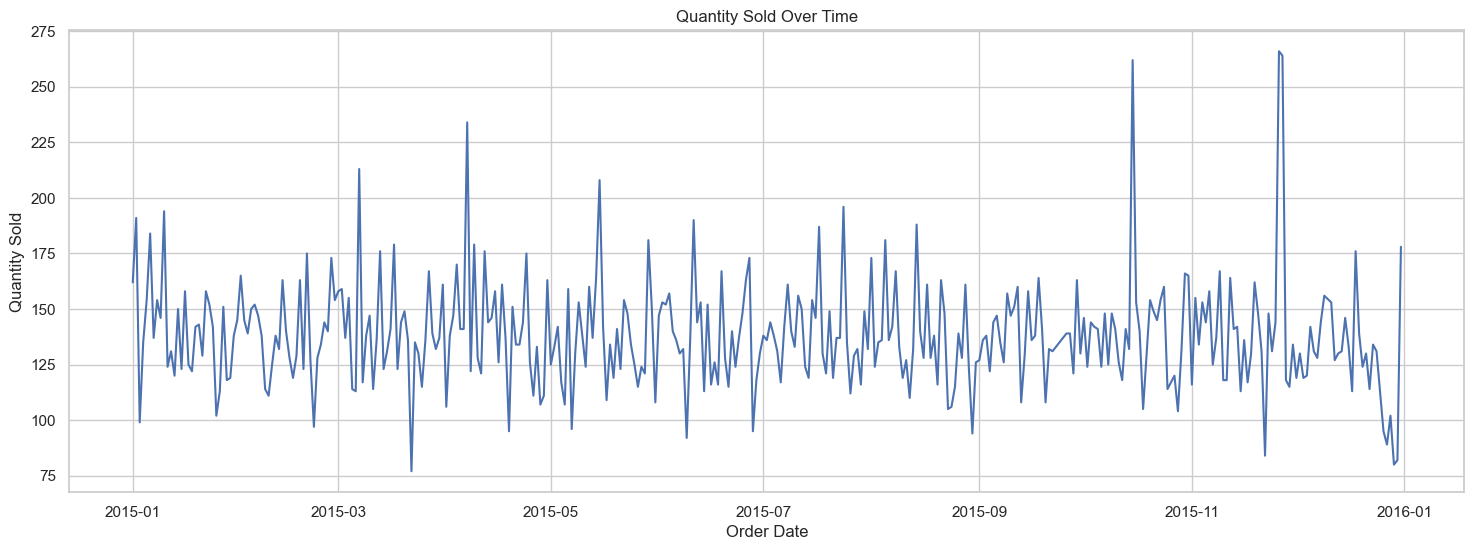

In [303]:
daily_sales = sales_data.groupby('order_date').agg({'quantity': 'sum'})
# Create the plot
plt.figure(figsize=(18, 6))
plt.plot(daily_sales.index, daily_sales.values)
plt.xlabel('Order Date')
plt.ylabel('Quantity Sold')
plt.title('Quantity Sold Over Time')
plt.grid(True)
plt.show()

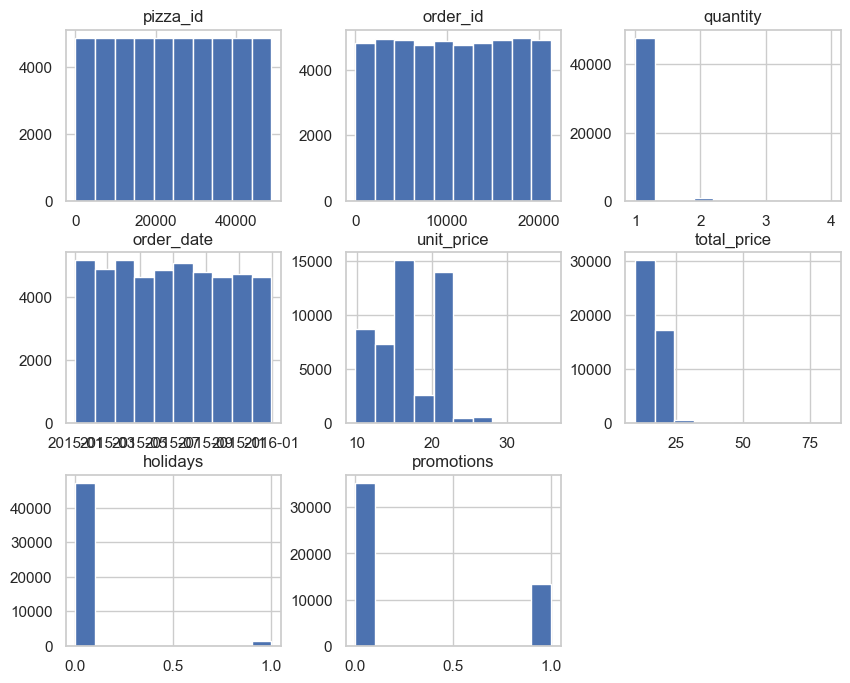

In [305]:
sales_data.hist(figsize=(10,8))
plt.show()

In [93]:
top_pizza = sel_mon.sort_values('quantity',ascending=False).head(7)

In [97]:
top_pizza

,quantity
pizza_name,
The Barbecue Chicken Pizza,224
The Pepperoni Pizza,224
The Classic Deluxe Pizza,204
The California Chicken Pizza,203
The Thai Chicken Pizza,194
The Hawaiian Pizza,189
The Sicilian Pizza,184


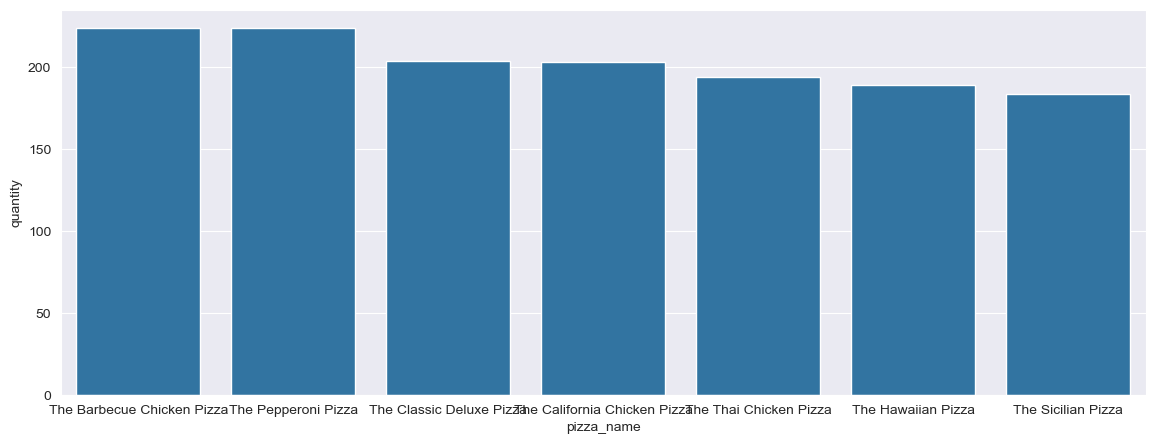

In [95]:
sns.set_style('darkgrid')

plt.figure(figsize=(14, 5))

sns.barplot(data = top_pizza, x = 'pizza_name', y = 'quantity' )

plt.show()

In [158]:
#sales by pizza size and category

In [160]:
merge_df.columns

Index(['pizza_id', 'order_id', 'pizza_name_id', 'quantity', 'order_date',
       'order_time', 'unit_price', 'total_price', 'pizza_size',
       'pizza_category', 'pizza_ingredients', 'pizza_name',
       'Items_Qty_In_Grams', 'day_of_week', 'month_name', 'week_number',
       'Year', 'holidays', 'promotions'],
      dtype='object')

In [170]:
size_group = merge_df.groupby('pizza_size')['quantity'].sum().reset_index()

In [164]:
category_group

,pizza_size,quantity
0,L,76628
1,M,62158
2,S,49293
3,XL,2760
4,XXL,140


C:\Users\rupsh\AppData\Local\Temp\ipykernel_25192\2041563222.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=size_group,x='pizza_size',y='quantity',palette='coolwarm')


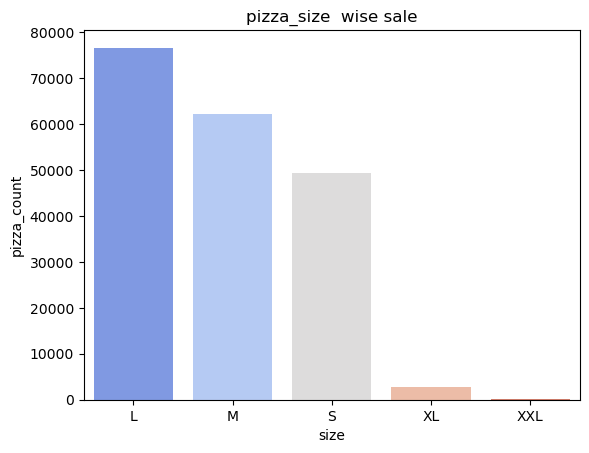

In [172]:
sns.barplot(data=size_group,x='pizza_size',y='quantity',palette='coolwarm')
plt.title('pizza_size  wise sale')
plt.xlabel('size')
plt.ylabel('pizza_count')
plt.show()

In [ ]:
#sales based on category

In [174]:
category_group = merge_df.groupby('pizza_category')['quantity'].sum().reset_index()

C:\Users\rupsh\AppData\Local\Temp\ipykernel_25192\1581381560.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=category_group,x='pizza_category',y='quantity',palette='coolwarm')


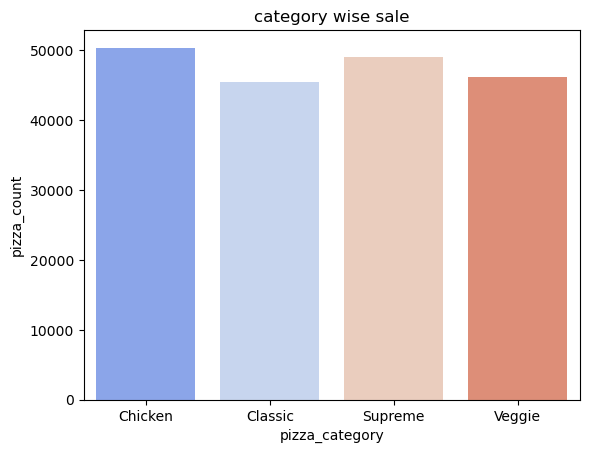

In [178]:
sns.barplot(data=category_group,x='pizza_category',y='quantity',palette='coolwarm')
plt.title('category wise sale')
plt.xlabel('pizza_category')
plt.ylabel('pizza_count')
plt.show()

In [ ]:
# seasonal sales trends and patterns

In [180]:
sales_by_day = merge_df.groupby('day_of_week')['total_price'].sum().reset_index()

In [182]:
sales_by_day

,day_of_week,total_price
0,0,437542.10
1,1,454238.80
2,2,460956.50
3,3,481875.80
4,4,512280.90
5,5,482354.20
6,6,401952.45


C:\Users\rupsh\AppData\Local\Temp\ipykernel_25192\985218702.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=sales_by_day, x='day_of_week', y='total_price', palette='viridis')


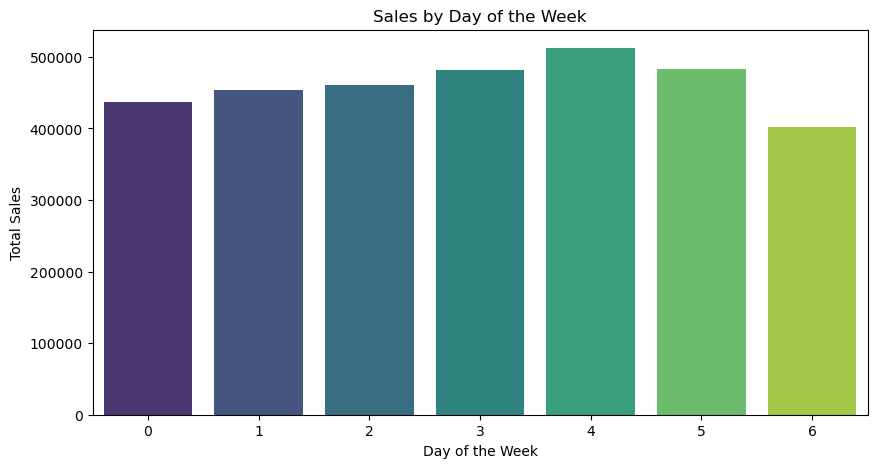

In [184]:
plt.figure(figsize=(10,5))
sns.barplot(data=sales_by_day, x='day_of_week', y='total_price', palette='viridis')
plt.title('Sales by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Total Sales')
plt.show()

In [ ]:
#sales by month

In [188]:
sales_by_month = merge_df.groupby('month_name')['total_price'].sum().reset_index()

C:\Users\rupsh\AppData\Local\Temp\ipykernel_25192\1223958851.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=sales_by_month, x='month_name', y='total_price', palette='magma')


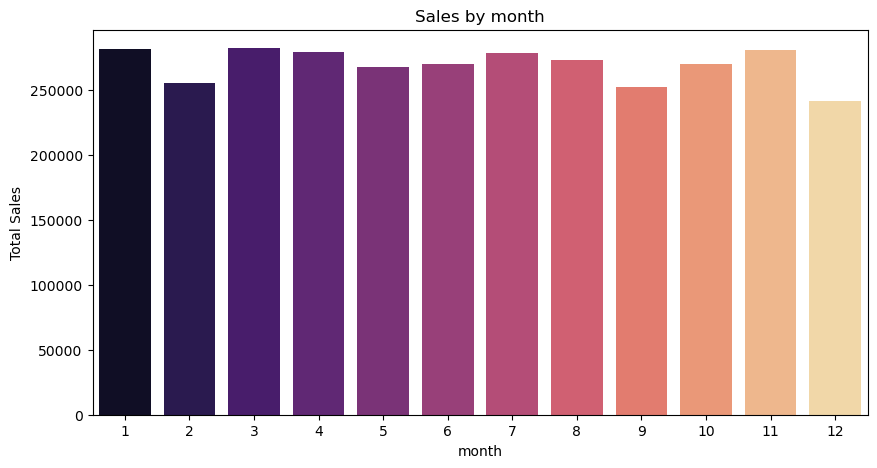

In [194]:
plt.figure(figsize=(10,5))
sns.barplot(data=sales_by_month, x='month_name', y='total_price', palette='magma')
plt.title('Sales by month')
plt.xlabel('month')
plt.ylabel('Total Sales')
plt.show()

In [196]:
#correlation analysis

In [198]:
corr = merge_df[['quantity', 'unit_price', 'total_price']].corr()

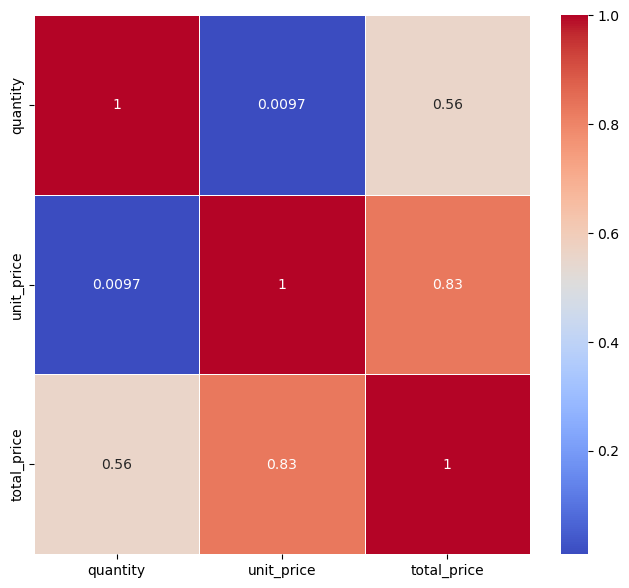

In [202]:
plt.figure(figsize=(8,7))
sns.heatmap(corr,annot=True,cmap='coolwarm',linewidths=0.5)
plt.show()

## Checking Outliers

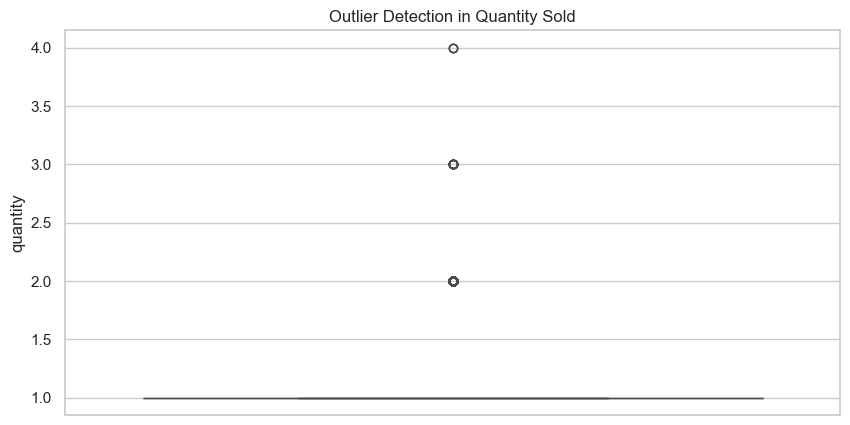

In [307]:
# Plot to check for outliers
plt.figure(figsize=(10, 5))
sns.boxplot(sales_data['quantity'])
plt.title('Outlier Detection in Quantity Sold')
plt.show()

In [309]:
# Remove extreme outliers if necessary
sales_data =sales_data[sales_data['quantity'] < sales_data['quantity'].quantile(0.99)]

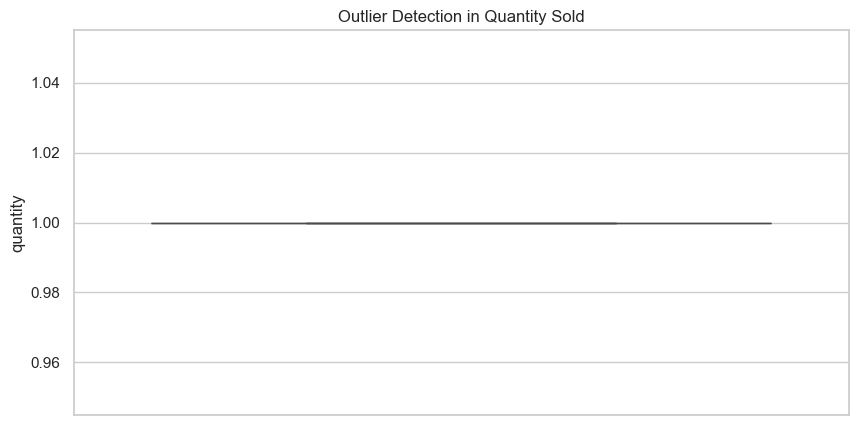

In [311]:
# Plot to check for outliers
plt.figure(figsize=(10, 5))
sns.boxplot(sales_data['quantity'])
plt.title('Outlier Detection in Quantity Sold')
plt.show()

## Stationarity Check

In [313]:
# Using  Augmented Dickey-Fuller test to check stationarity

# H0: it is not stationary
# H1: it is stationary

def adf_test(sales_data):
  result = adfuller(sales_data)
  print('ADF Statistic: %f' % result[0])
  print('p-value: %f' % result[1])
  print(f'# Lags used: {result[2]}')
  print(f'No of observations used: {result[3]}')
  if result[1] <= 0.05:
    print('we reject the null hypothesis, The series is stationary')
  else:
    print('Not enough statistical evidence to reject null hypothesis, The series is not stationary')

In [319]:
adf_test(daily_sales)

ADF Statistic: -4.864377
p-value: 0.000041
# Lags used: 15
No of observations used: 342
we reject the null hypothesis, The series is stationary


Check Stationarity:
Used the Augmented Dickey-Fuller (ADF) test to determine if the series is stationary. A stationary series has
constant mean and variance over time. If the p-value from the test is above 0.05, the series is not stationary, and differencing is required.

## Autocorrelation and partial Autocorrelation

Autocorrelation Function (ACF):

The ACF plot shows the correlation of the series with its lags. Use the ACF to identify q (the number of lagged forecast errors in the ARIMA model). 
Look for the point where the ACF plot cuts off (significant lags end abruptly).

Partial Autocorrelation Function (PACF):

The PACF plot shows the correlation of the series with its lags after removing the effects of intermediate lags. Use the PACF to identify p (the number of lagged terms in the ARIMA model). Look for the point where the PACF plot cuts off.

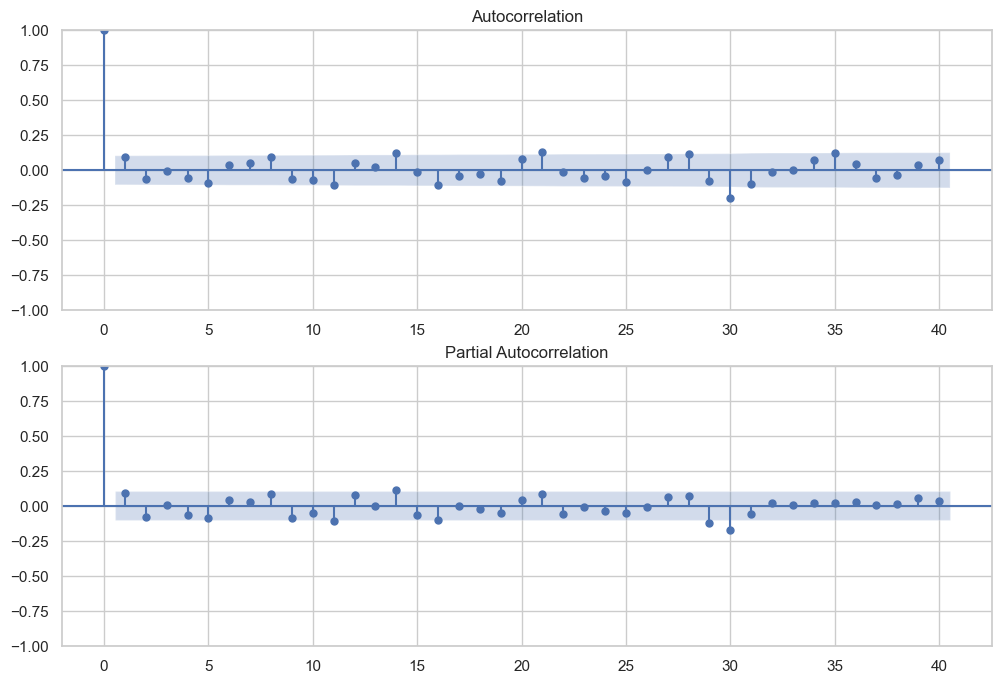

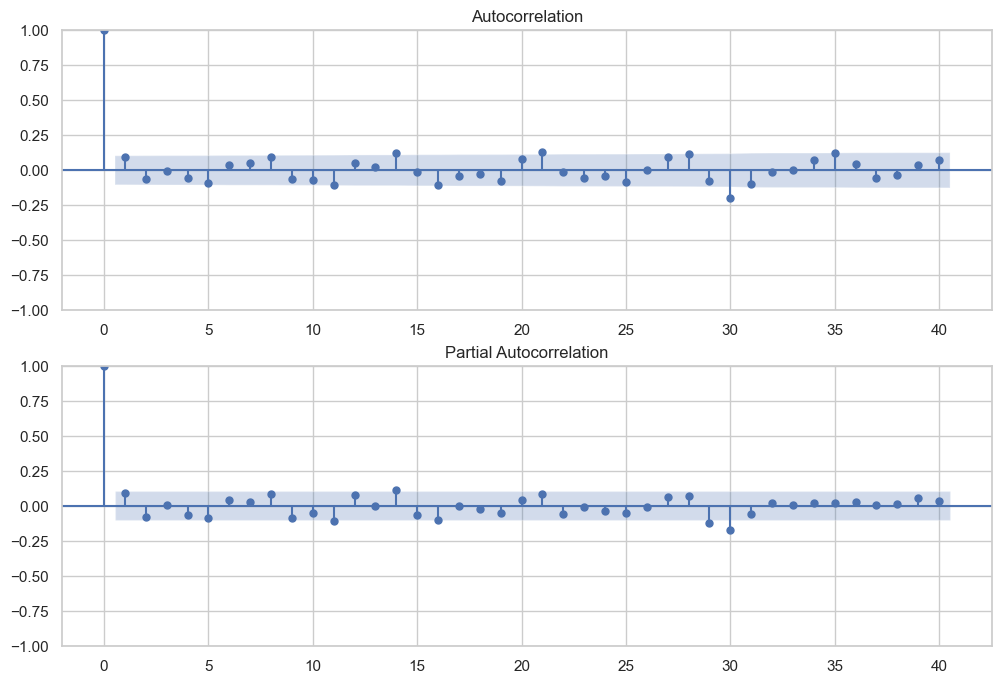

In [355]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)

# Acf plot
fig = plot_acf(daily_sales, lags=40, ax=ax1)
ax2 = fig.add_subplot(212)

# pacf plot 
fig = plot_pacf(daily_sales, lags=40, ax=ax2)
plt.show()

The ACF cuts off sharply after lag 2, indicating that the moving average component q=2. PACF Plot:

The PACF cuts off sharply after lag 1, indicating that the autoregressive component p=1.

## Sales Prediction

In [359]:
# Predicting sales of pizzas for next 7  days using ARIMA, SARIMA, Prophet, LSTM 
# choosing best model base on MAPE score(mean_absolute_percentage_error)

In [367]:
data = sales_data.groupby(['order_date', 'pizza_name'])['quantity'].sum().unstack().fillna(0)
data.head()

pizza_name,The Barbecue Chicken Pizza,The Big Meat Pizza,The Brie Carre Pizza,The Calabrese Pizza,The California Chicken Pizza,The Chicken Alfredo Pizza,The Chicken Pesto Pizza,The Classic Deluxe Pizza,The Five Cheese Pizza,The Four Cheese Pizza,...,The Prosciutto and Arugula Pizza,The Sicilian Pizza,The Soppressata Pizza,The Southwest Chicken Pizza,The Spicy Italian Pizza,The Spinach Pesto Pizza,The Spinach Supreme Pizza,The Spinach and Feta Pizza,The Thai Chicken Pizza,The Vegetables + Vegetables Pizza
order_date,,,,,,,,,,,,,,,,,,,,,
2015-01-01,11.00,5.00,0.00,1.00,4.00,2.00,4.00,10.00,7.00,6.00,...,4.00,4.00,1.00,7.00,5.00,2.00,5.00,2.00,8.00,3.00
2015-01-02,12.00,5.00,3.00,7.00,15.00,3.00,2.00,13.00,5.00,6.00,...,6.00,5.00,3.00,9.00,9.00,5.00,3.00,4.00,8.00,1.00
2015-01-03,2.00,3.00,1.00,1.00,6.00,0.00,1.00,4.00,5.00,4.00,...,1.00,2.00,0.00,9.00,4.00,3.00,0.00,5.00,4.00,6.00
2015-01-04,2.00,3.00,0.00,2.00,3.00,3.00,2.00,8.00,7.00,6.00,...,4.00,8.00,6.00,10.00,4.00,4.00,6.00,1.00,3.00,5.00
2015-01-05,6.00,1.00,1.00,4.00,11.00,2.00,3.00,9.00,4.00,4.00,...,5.00,5.00,0.00,6.00,5.00,2.00,4.00,5.00,10.00,6.00


In [371]:
one_pizza = data['The Barbecue Chicken Pizza']

In [375]:
# Train-Test Split
train = one_pizza[:-30]  # Use all but the last 30 days for training
test = one_pizza[-30:]   # Use the last 30 days for testing

In [377]:
train = train.fillna(train.median())

## model selection

ARIMA / SARIMA ARIMA (AutoRegressive Integrated Moving Average) and SARIMA (Seasonal ARIMA) are great starting points if your data shows seasonal patterns and trends.

In [205]:
pip install statsmodels

Note: you may need to restart the kernel to use updated packages.


In [207]:
pip install pmdarima

   ---------------------------------------- 0.0/625.1 kB ? eta -:--:--
   ---------------------------------------- 0.0/625.1 kB ? eta -:--:--
   ---------------------------------------- 0.0/625.1 kB ? eta -:--:--
   ---------------------------------------- 0.0/625.1 kB ? eta -:--:--
   ---------------------------------------- 0.0/625.1 kB ? eta -:--:--
   ---------------------------------------- 0.0/625.1 kB ? eta -:--:--
   ---------------------------------------- 0.0/625.1 kB ? eta -:--:--
   ---------------------------------------- 0.0/625.1 kB ? eta -:--:--
   ---------------- ----------------------- 262.1/625.1 kB ? eta -:--:--
   ---------------- ----------------------- 262.1/625.1 kB ? eta -:--:--
   ---------------- ----------------------- 262.1/625.1 kB ? eta -:--:--
   ------------------------------- ------ 524.3/625.1 kB 328.9 kB/s eta 0:00:01
   ------------------------------- ------ 524.3/625.1 kB 328.9 kB/s eta 0:00:01
   ------------------------------- ------ 524.3/625.1

### ARIMA model

. p (AutoRegressive term): The number of past observations (lags) used to predict the future value.
. d (Differencing term): The number of times the data is differenced to make it stationary.
. q (Moving Average term): The number of past forecast errors used to improve future predictions.

In [379]:
print(train.index)

DatetimeIndex(['2015-01-01', '2015-01-02', '2015-01-03', '2015-01-04',
               '2015-01-05', '2015-01-06', '2015-01-07', '2015-01-08',
               '2015-01-09', '2015-01-10',
               ...
               '2015-11-20', '2015-11-21', '2015-11-22', '2015-11-23',
               '2015-11-24', '2015-11-25', '2015-11-26', '2015-11-27',
               '2015-11-28', '2015-11-29'],
              dtype='datetime64[ns]', name='order_date', length=328, freq=None)


In [381]:
train.index = pd.to_datetime(train.index)
train = train.asfreq('D')  # 'D' for daily, adjust based on your data's frequency

In [383]:
train

order_date
2015-01-01   11.00
2015-01-02   12.00
2015-01-03    2.00
2015-01-04    2.00
2015-01-05    6.00
              ... 
2015-11-25    3.00
2015-11-26    9.00
2015-11-27   13.00
2015-11-28    8.00
2015-11-29    4.00
Freq: D, Name: The Barbecue Chicken Pizza, Length: 333, dtype: float64

In [389]:
# Fit ARIMA model (order=(1, 1, 1) as a starting point; optimize based on AIC/BIC)
arima_model = ARIMA(train, order=(1, 0, 2))
arima_result = arima_model.fit()

# Forecast
arima_forecast = arima_result.forecast(steps=len(test))

# Evaluate ARIMA Model
arima_mape = mean_absolute_percentage_error(test, arima_forecast)

print("ARIMA Model MAPE:", arima_mape)

ARIMA Model MAPE: 0.4916207271258181


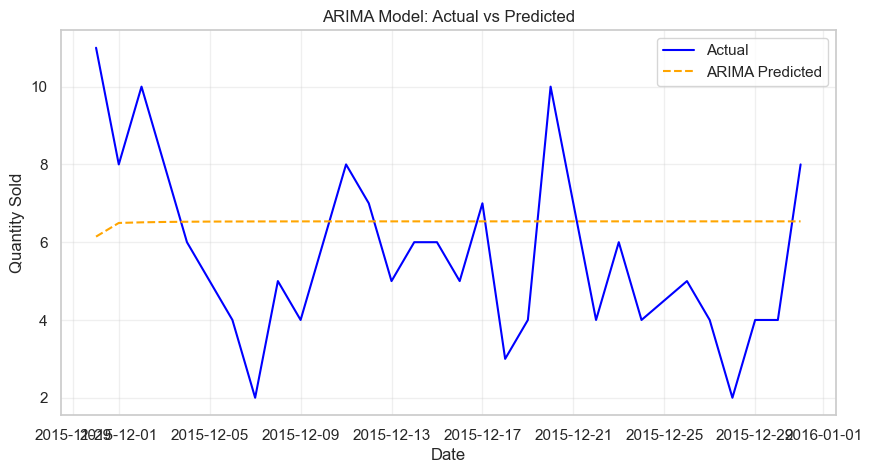

In [391]:
# Plot Actual vs Predicted
plt.figure(figsize=(10, 5))
plt.plot(test.index, test, label='Actual', color='blue')
plt.plot(test.index, arima_forecast, label='ARIMA Predicted', linestyle='--', color='orange')
plt.title('ARIMA Model: Actual vs Predicted')
plt.xlabel('Date')
plt.ylabel('Quantity Sold')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

ARIMA model is appearing to predict a flat trend, not capturing the variability in actual sales

### SARIMAX MODEL


SARIMA (Seasonal AutoRegressive Integrated Moving Average) is a statistical model used for forecasting time series data that exhibits both trends and seasonal patterns.

SARIMA(p, d, q)(P, D, Q, s)

p, d, q: Non-seasonal autoregressive, differencing, and moving average terms

P, D, Q: Seasonal autoregressive, differencing, and moving average terms

s: The number of time steps in a season (e.g., 7 for weekly seasonality)

In [395]:
# Fit SARIMA model (seasonal_order=(1, 1, 1, 7) for weekly seasonality; adjust as needed)
sarima_model = SARIMAX(train, order=(1, 1, 1), seasonal_order=(1, 1, 1, 7))
sarima_result = sarima_model.fit()

# Forecast
sarima_forecast = sarima_result.forecast(steps=len(test))

# Evaluate SARIMA Model
sarima_mape = mean_absolute_percentage_error(test, sarima_forecast)

print("SARIMA Model MAPE:", sarima_mape)

SARIMA Model MAPE: 0.44297837800258727


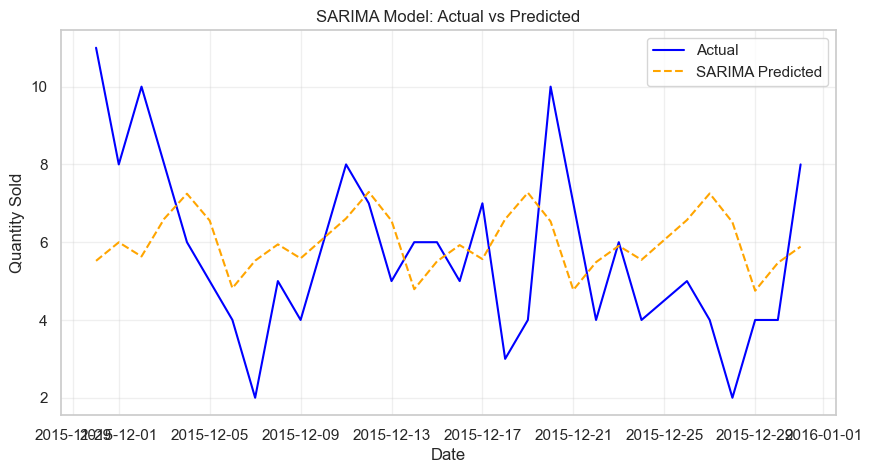

In [399]:
# Plot Actual vs Predicted
plt.figure(figsize=(10, 5))
plt.plot(test.index, test, label='Actual', color='blue')
plt.plot(test.index, sarima_forecast, label='SARIMA Predicted', linestyle='--', color='orange')
plt.title('SARIMA Model: Actual vs Predicted')
plt.xlabel('Date')
plt.ylabel('Quantity Sold')
plt.legend()
plt.grid(alpha=0.3)
plt.show()
     

SARIMA predictions show periodic peaks and dips, indicating it captures seasonality better than ARIMA.
However, there’s still a lag in capturing sudden changes in sales
Prophet Model

### Prophet


Prophet is an open-source time series forecasting library developed by Facebook (Meta).It is based on an additive model where non-linear trends are fit with yearly, weekly, and daily seasonality, plus holiday effects. It works best with time series that have strong seasonal effects and several seasons of historical data.

Model: Additive model – y(t) = trend + seasonality + holidays + error

In [402]:
# Prepare data for Prophet
prophet_data = one_pizza.reset_index()
prophet_data.columns = ['ds', 'y']

# Train-Test Split
prophet_train = prophet_data[:-30]
prophet_test = prophet_data[-30:]

# Fit Prophet Model
prophet_model =  Prophet()
prophet_model.fit(prophet_train)

# Forecast
future_dates = prophet_model.make_future_dataframe(periods=30)
prophet_forecast = prophet_model.predict(future_dates)

# Extract only test period forecast
prophet_test_forecast = prophet_forecast[-30:]['yhat']

# Evaluate Prophet Model
prophet_mape = mean_absolute_percentage_error(prophet_test['y'], prophet_test_forecast)

print("Prophet Model MAPE:", prophet_mape)

13:40:02 - cmdstanpy - INFO - Chain [1] start processing
13:40:03 - cmdstanpy - INFO - Chain [1] done processing


Prophet Model MAPE: 0.4386107765641858


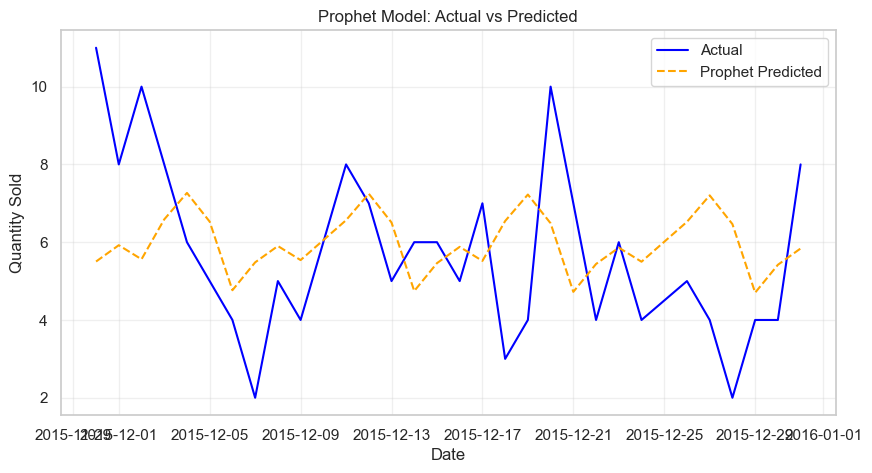

In [404]:
plt.figure(figsize=(10, 5))
plt.plot(prophet_test['ds'], prophet_test['y'], label='Actual', color='blue')
plt.plot(prophet_test['ds'], prophet_test_forecast, label='Prophet Predicted', linestyle='--', color='orange')
plt.title('Prophet Model: Actual vs Predicted')
plt.xlabel('Date')
plt.ylabel('Quantity Sold')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

Prophet captures seasonal variations well, closely following the periodic fluctuations of actual sales.
Some deviations are present during sharp changes, but overall, Prophet performs robustly

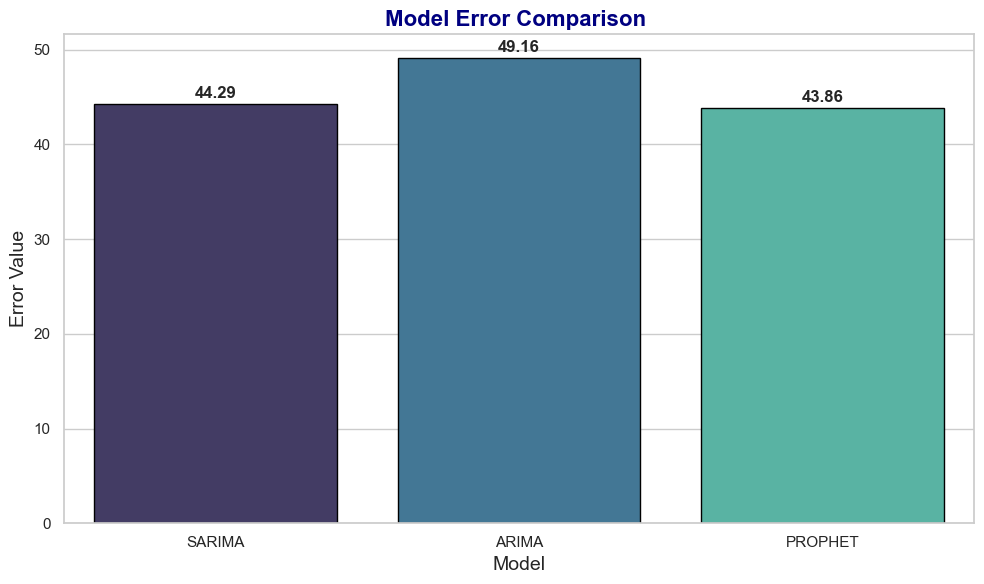

In [407]:
# Data
MODEL = ['SARIMA', 'ARIMA', 'PROPHET']
VALUE = [44.29,49.16,43.86]

# Set Seaborn theme
sns.set_theme(style="whitegrid")

# Create figure
plt.figure(figsize=(10,6))
barplot = sns.barplot(x=MODEL, y=VALUE, palette="mako", edgecolor='black')

# Annotate bars neatly above
for index, value in enumerate(VALUE):
    plt.text(index, value + 0.3, f'{value:.2f}', ha='center', va='bottom', fontweight='bold', fontsize=12)

# Titles and labels
plt.title('Model Error Comparison ', fontsize=16, fontweight='bold', color='navy')
plt.xlabel('Model', fontsize=14)
plt.ylabel('Error Value', fontsize=14)

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()

     

 On comparing all the models Prophet model got selected due to its lowest mape score

## Sales Forecasting: Predicting pizza sales for the next one week using the trained Prophet model.

In [417]:
# Initialize dictionary to store forecasts
all_forecasts = {}

# Loop through each pizza type
for pizza in data.columns:  # data contains daily sales of each pizza
    one_pizza_sales = data[pizza].reset_index()
    one_pizza_sales.columns = ['ds', 'y']  # Prophet requires columns ['ds', 'y']

    prophet_model = Prophet()
    prophet_model.fit(one_pizza_sales)

    # Forecast for the next 7 days
    future_dates = prophet_model.make_future_dataframe(periods=7)
    forecast = prophet_model.predict(future_dates)
    
    # Store forecasted values (last 7 days)
    all_forecasts[pizza] = forecast.iloc[-7:]['yhat'].values

# Convert forecasts into a DataFrame
forecast_df = pd.DataFrame(all_forecasts)
forecast_df.index = pd.date_range(start=data.index[-1] + pd.Timedelta(days=1), periods=7)
forecast_df

14:35:40 - cmdstanpy - INFO - Chain [1] start processing
14:35:40 - cmdstanpy - INFO - Chain [1] done processing
14:35:40 - cmdstanpy - INFO - Chain [1] start processing
14:35:40 - cmdstanpy - INFO - Chain [1] done processing
14:35:40 - cmdstanpy - INFO - Chain [1] start processing
14:35:40 - cmdstanpy - INFO - Chain [1] done processing
14:35:41 - cmdstanpy - INFO - Chain [1] start processing
14:35:41 - cmdstanpy - INFO - Chain [1] done processing
14:35:41 - cmdstanpy - INFO - Chain [1] start processing
14:35:41 - cmdstanpy - INFO - Chain [1] done processing
14:35:41 - cmdstanpy - INFO - Chain [1] start processing
14:35:41 - cmdstanpy - INFO - Chain [1] done processing
14:35:41 - cmdstanpy - INFO - Chain [1] start processing
14:35:41 - cmdstanpy - INFO - Chain [1] done processing
14:35:41 - cmdstanpy - INFO - Chain [1] start processing
14:35:41 - cmdstanpy - INFO - Chain [1] done processing
14:35:41 - cmdstanpy - INFO - Chain [1] start processing
14:35:41 - cmdstanpy - INFO - Chain [1]

,The Barbecue Chicken Pizza,The Big Meat Pizza,The Brie Carre Pizza,The Calabrese Pizza,The California Chicken Pizza,The Chicken Alfredo Pizza,The Chicken Pesto Pizza,The Classic Deluxe Pizza,The Five Cheese Pizza,The Four Cheese Pizza,...,The Prosciutto and Arugula Pizza,The Sicilian Pizza,The Soppressata Pizza,The Southwest Chicken Pizza,The Spicy Italian Pizza,The Spinach Pesto Pizza,The Spinach Supreme Pizza,The Spinach and Feta Pizza,The Thai Chicken Pizza,The Vegetables + Vegetables Pizza
2016-01-01,7.07,4.96,1.47,2.83,6.89,3.37,3.19,7.65,3.98,5.62,...,4.64,6.05,2.85,5.85,5.59,3.42,2.95,4.58,6.70,4.38
2016-01-02,6.33,5.01,1.21,2.84,5.83,2.93,2.47,7.07,2.92,5.54,...,3.71,6.02,2.54,5.01,5.33,2.75,2.36,3.46,6.38,4.37
2016-01-03,4.74,4.35,1.52,2.28,5.07,2.14,2.50,5.77,2.75,4.36,...,3.59,4.40,2.13,4.27,4.24,2.57,2.04,3.35,5.47,3.77
2016-01-04,5.39,4.64,1.43,3.09,5.97,2.75,2.77,6.81,3.03,4.70,...,3.64,4.41,2.13,5.31,4.73,2.46,2.20,3.94,6.82,3.96
2016-01-05,5.76,4.30,1.57,2.74,5.35,2.49,2.00,6.94,3.56,4.70,...,4.19,4.82,3.02,5.10,5.04,2.74,2.22,3.34,6.11,3.54
2016-01-06,5.47,4.59,1.59,2.90,5.66,2.54,2.76,6.59,3.13,5.24,...,3.75,5.43,2.56,4.80,5.04,2.45,2.26,3.84,5.94,4.29
2016-01-07,6.48,4.99,1.73,2.84,6.01,2.73,2.95,6.94,3.52,5.71,...,3.72,5.40,2.61,5.44,5.59,2.65,2.48,3.99,6.50,4.51


In [419]:
# Round the forecasted number of pizzas to the nearest whole number
forecast_df = forecast_df.round()

# Display the updated forecast DataFrame
forecast_df

,The Barbecue Chicken Pizza,The Big Meat Pizza,The Brie Carre Pizza,The Calabrese Pizza,The California Chicken Pizza,The Chicken Alfredo Pizza,The Chicken Pesto Pizza,The Classic Deluxe Pizza,The Five Cheese Pizza,The Four Cheese Pizza,...,The Prosciutto and Arugula Pizza,The Sicilian Pizza,The Soppressata Pizza,The Southwest Chicken Pizza,The Spicy Italian Pizza,The Spinach Pesto Pizza,The Spinach Supreme Pizza,The Spinach and Feta Pizza,The Thai Chicken Pizza,The Vegetables + Vegetables Pizza
2016-01-01,7.00,5.00,1.00,3.00,7.00,3.00,3.00,8.00,4.00,6.00,...,5.00,6.00,3.00,6.00,6.00,3.00,3.00,5.00,7.00,4.00
2016-01-02,6.00,5.00,1.00,3.00,6.00,3.00,2.00,7.00,3.00,6.00,...,4.00,6.00,3.00,5.00,5.00,3.00,2.00,3.00,6.00,4.00
2016-01-03,5.00,4.00,2.00,2.00,5.00,2.00,3.00,6.00,3.00,4.00,...,4.00,4.00,2.00,4.00,4.00,3.00,2.00,3.00,5.00,4.00
2016-01-04,5.00,5.00,1.00,3.00,6.00,3.00,3.00,7.00,3.00,5.00,...,4.00,4.00,2.00,5.00,5.00,2.00,2.00,4.00,7.00,4.00
2016-01-05,6.00,4.00,2.00,3.00,5.00,2.00,2.00,7.00,4.00,5.00,...,4.00,5.00,3.00,5.00,5.00,3.00,2.00,3.00,6.00,4.00
2016-01-06,5.00,5.00,2.00,3.00,6.00,3.00,3.00,7.00,3.00,5.00,...,4.00,5.00,3.00,5.00,5.00,2.00,2.00,4.00,6.00,4.00
2016-01-07,6.00,5.00,2.00,3.00,6.00,3.00,3.00,7.00,4.00,6.00,...,4.00,5.00,3.00,5.00,6.00,3.00,2.00,4.00,7.00,5.00


## Ingredient Calculation

In [421]:
ing_data.head()

,Unnamed: 0,pizza_name_id,pizza_name,pizza_ingredients,Items_Qty_In_Grams
0,0,bbq_ckn_l,The Barbecue Chicken Pizza,Barbecued Chicken,40.00
1,1,bbq_ckn_l,The Barbecue Chicken Pizza,Red Peppers,15.00
2,2,bbq_ckn_l,The Barbecue Chicken Pizza,Green Peppers,20.00
3,3,bbq_ckn_l,The Barbecue Chicken Pizza,Tomatoes,30.00
4,4,bbq_ckn_l,The Barbecue Chicken Pizza,Red Onions,60.00


In [444]:
ingredient_forecast = []

# Loop through each pizza in forecast_df
for pizza in forecast_df.columns:
    # Get the total forecasted sales for the pizza (sum across 7 days)
    total_sales = forecast_df[pizza].sum()
    # Get the ingredient requirements for the pizza from ingredients_data
    pizza_ingredients = ing_data[ing_data['pizza_name'] == pizza]
    
    # Calculate total ingredient requirements
    for _, row in pizza_ingredients.iterrows():
        ingredient_forecast.append({
            'ingredient': row['pizza_ingredients'],  # Ingredient name
            'quantity_needed': total_sales * row['Items_Qty_In_Grams']  # Forecast * quantity per pizza
        })

# Convert to DataFrame
ingredient_forecast_df = pd.DataFrame(ingredient_forecast)
# Summarize by ingredient
final_purchase_order = ingredient_forecast_df.groupby('ingredient').agg({'quantity_needed': 'sum'}).reset_index()
# Add a unit column (e.g., grams)
final_purchase_order['unit'] = 'grams'

# Display the final purchase order
print("Final Purchase Order:")
pd.set_option('display.max_rows',64)
final_purchase_order
    



Final Purchase Order:


,ingredient,quantity_needed,unit
0,?duja Salami,2400.00,grams
1,Alfredo Sauce,855.00,grams
2,Anchovies,2380.00,grams
3,Artichokes,6750.00,grams
4,Arugula,870.00,grams
5,Asiago Cheese,3660.00,grams
6,Bacon,18180.00,grams
7,Barbecue Sauce,1200.00,grams
8,Barbecued Chicken,3600.00,grams
9,Beef Chuck Roast,15960.00,grams
